# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [3]:
# Write your answer here

# Ebola Folder 
DATA_FOLDER_ebola = DATA_FOLDER + '/ebola'
# Directories in the folder
ebola_directories = os.listdir(DATA_FOLDER_ebola)
# Remove License File
del ebola_directories[ebola_directories.index('LICENSE')]

# Names of the columns which contain the total number of daily incidents
data_columns = {'liberia':['Date','Variable', 'National'],
                'sl': ['date','variable', 'National'],
                'guinea':['Date','Description', 'Totals']
               }

### Load All CSV Files Contained In One Folder
TODO : write the explanatory paragraph

In [4]:
# Loads the information relevant to deaths and cases within the csv files contained in the directory for a given country

def load_csv_files_into_dataframe(folder, country):
    country_folder = folder + '/'+ country +'_data'
    csv_files = os.listdir(country_folder)    
    
    all_data = pd.DataFrame()
    
    date = data_columns[country][0]
    description = data_columns[country][1]
    totals = data_columns[country][2]
    
    for i, file in enumerate(csv_files):
        
        daily_csv = pd.read_csv(country_folder + '/' +file)
        
        # Find columns containing death or case keywords
        motives  = daily_csv[description][daily_csv[description].str.contains("death|case|Death|Case")]
        # Create a dictionary with the date and country
        daily_dict = {'Date': file[:10], 'Country':country}
        # Add the motives with corresponding total / national values to the dictionary
        daily_dict.update(dict(zip(motives.tolist(), daily_csv[totals][motives.index].tolist())))
        # Append the dictionary to the dataframe
        all_data = all_data.append(daily_dict, ignore_index = True)

    all_data.Date = pd.to_datetime(all_data.Date)
    all_data['Month']  = all_data.Date.dt.month
    all_data.set_index(['Date','Country'], inplace = True)
    return all_data

### Liberia Dataset

In [5]:
liberia_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'liberia')
liberia_data.head()

,,Case Fatality Rate (CFR) - Confirmed & Probable Cases,Cumulative cases among HCW,Cumulative deaths among HCW,New Case/s (Probable),New Case/s (Suspected),New case/s (confirmed),Newly Reported Cases in HCW,Newly Reported deaths in HCW,Newly reported deaths,Total Number of Confirmed Cases of Guinean Nationality,...,Total Case/s (Probable),Total Case/s (Suspected),Total case/s (confirmed),"Cumulative confirmed, probable and suspected cases","Total death/s in confirmed, probable, suspected cases",Case Fatality Rate (CFR) - Confirmed & Probable Cases,Total Number of Confirmed Cases of Guinean Nationality,Total Number of Confirmed Cases of Sierra Leonean Nationality,"Total death/s in confirmed, probable, suspected cases",Month
Date,Country,,,,,,,,,,,,,,,,,,,,,
2014-06-16,liberia,NaN,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2014-06-17,liberia,NaN,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2014-06-22,liberia,25.0,1.0,1.0,0.0,5.0,5.0,4.0,0.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2014-06-24,liberia,NaN,2.0,2.0,0.0,2.0,4.0,0.0,0.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2014-06-25,liberia,NaN,4.0,3.0,1.0,4.0,2.0,2.0,1.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [6]:
liberia_monthly = liberia_data[['New case/s (confirmed)', 'Newly reported deaths', 'Month']].groupby(['Month'])
print(liberia_data[['New case/s (confirmed)', 'Newly reported deaths', 'Month']].cumsum())

                    New case/s (confirmed)  Newly reported deaths  Month
Date       Country                                                      
2014-06-16 liberia                     1.0                    2.0    6.0
2014-06-17 liberia                     1.0                    2.0   12.0
2014-06-22 liberia                     6.0                    6.0   18.0
2014-06-24 liberia                    10.0                   10.0   24.0
2014-06-25 liberia                    12.0                   13.0   30.0
2014-06-28 liberia                    13.0                   14.0   36.0
2014-06-29 liberia                    15.0                   14.0   42.0
2014-07-01 liberia                    17.0                   19.0   49.0
2014-07-02 liberia                    17.0                   24.0   56.0
2014-07-03 liberia                    18.0                   28.0   63.0
2014-07-07 liberia                    23.0                   30.0   70.0
2014-07-08 liberia                    23.0         

### Guinea Dataset

In [7]:
guinea_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'guinea')
guinea_monthly = guinea_data[['Month']]

In [8]:
guinea_monthly = guinea_data.groupby(['Month'])

### Sierra Leone Dataset

In [9]:
sl_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'sl')

sl_data.head()

,,cum_noncase,death_confirmed,death_probable,death_suspected,etc_cum_deaths,etc_new_deaths,new_noncase,Month
Date,Country,,,,,,,,
2014-08-12,sl,657,264,34,5,NaN,NaN,4,8
2014-08-13,sl,680,273,34,5,NaN,NaN,13,8
2014-08-14,sl,708,280,34,5,NaN,NaN,26,8
2014-08-15,sl,726,287,34,5,NaN,NaN,15,8
2014-08-16,sl,741,297,34,5,NaN,NaN,9,8


In [10]:
sl_monthly = sl_data.groupby(['Month'])

# TODO :  
- Decide on what is a case and a death for each country -> add new columns to the existing df
- Merge the new columns of the 3 countries with the indexes to create the final df 

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [116]:
# Write your answer here
DATA_FOLDER_microbiome = DATA_FOLDER + '/microbiome'

# Get all the files in the folder
microbiome_cvs_files = os.listdir(DATA_FOLDER_microbiome)
# Get the 9 first spreadsheets
RNA_seq_files = [x for x in microbiome_cvs_files if 'MID' in x]
# Get the last spreadsheet
metadata_file = [x for x in microbiome_cvs_files if x not in RNA_seq_files]

# Load the metadata into a dataframe
metadata_df = pd.read_excel((DATA_FOLDER_microbiome + '/' + metadata_file[0]))
metadata_columns = metadata_df.columns.values

# Create the dataframe
microbiome_data = pd.DataFrame(index = [])

# Load the 9 spreadsheets into one dataframe
for file in RNA_seq_files:
    # Load the xls file
    df = pd.read_excel(DATA_FOLDER_microbiome + '/' +file,header= None)
    # Get the name of the barcode for the given file
    Barcode_idx = file.replace('.xls','')
    # Get the metadata associated to the given barcode
    file_metadata = metadata_df[metadata_df['BARCODE'].str.contains(Barcode_idx)].values[0]
    
    # Save the metadata to the dataframe
    for c, col in enumerate(metadata_columns):
        df[col] = file_metadata[c]

    # Merge it with the whole dataframe
    microbiome_data = pd.concat([microbiome_data,df])

# Rename the columns
microbiome_data = microbiome_data.rename(columns={0:'FULL NAME', 1:'NUMBER'})
# Create a dataframe with the families of microbes
microbiome_categories = microbiome_data['FULL NAME'].apply(lambda x: pd.Series(x.split(' ')))
families = {i: "Family"+str(i) for i in range(8)}
microbiome_categories.rename(columns=families,inplace=True)
# Concatenate the data
microbiome_data = pd.concat([microbiome_categories, microbiome_data], axis=1)

# Replace all nan values with unknown
microbiome_data = microbiome_data.replace(np.nan, 'unknown', regex=True)
# Index to have a unique classification
microbiome_data = microbiome_data.set_index(families.values() +['GROUP', 'SAMPLE'])
print("Index is unique : " + str(microbiome_data.index.is_unique))


grouped_microbiome_data = microbiome_data.groupby(families.values())
microbiome_data.head()



Index is unique : True


FULL NAME  \
Family0 Family1         Family2           Family3           Family4            Family5      Family6 Family7 GROUP              SAMPLE                                                       
Archaea "Crenarchaeota" Thermoprotei      Desulfurococcales Desulfurococcaceae Ignisphaera  unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Desulfuro...   
                                                            Pyrodictiaceae     Pyrolobus    unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Desulfuro...   
                                          Sulfolobales      Sulfolobaceae      Stygiolobus  unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Sulfoloba...   
                                          Thermoproteales   Thermofilaceae     Thermofilum  unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Thermopro...   
        "Euryarchaeota" "Methanomicrobia" Methanocellales   Methanocellaceae   Methanocella unknown unknown EXTRACTION CONTROL unknown  Archaea "Euryarchaeota" "Methanomicrobia" Meth...   

                                                                                                                                        NUMBER  \
Family0 Family1         Family2           Family3           Family4            Family5      Family6 Family7 GROUP              SAMPLE            
Archaea "Crenarchaeota" Thermoprotei      Desulfurococcales Desulfurococcaceae Ignisphaera  unknown unknown EXTRACTION CONTROL unknown       7   
                                                            Pyrodictiaceae     Pyrolobus    unknown unknown EXTRACTION CONTROL unknown       2   
                                          Sulfolobales      Sulfolobaceae      Stygiolobus  unknown unknown EXTRACTION CONTROL unknown       3   
                                          Thermoproteales   Thermofilaceae     Thermofilum  unknown unknown EXTRACTION CONTROL unknown       3   
        "Euryarchaeota" "Methanomicrobia" Methanocellales   Methanocellaceae   Methanocella unknown unknown EXTRACTION CONTROL unknown       7   

                                                                                                                                       BARCODE  
Family0 Family1         Family2           Family3           Family4            Family5      Family6 Family7 GROUP              SAMPLE           
Archaea "Crenarchaeota" Thermoprotei      Desulfurococcales Desulfurococcaceae Ignisphaera  unknown unknown EXTRACTION CONTROL unknown    MID1  
                                                            Pyrodictiaceae     Pyrolobus    unknown unknown EXTRACTION CONTROL unknown    MID1  
                                          Sulfolobales      Sulfolobaceae      Stygiolobus  unknown unknown EXTRACTION CONTROL unknown    MID1  
                                          Thermoproteales   Thermofilaceae     Thermofilum  unknown unknown EXTRACTION CONTROL unknown    MID1  
        "Euryarchaeota" "Methanomicrobia" Methanocellales   Methanocellaceae   Methanocella unknown unknown EXTRACTION CONTROL unknown    MID1

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [12]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Importing Seaborn for Color Palettes

In [13]:
import seaborn as sns

# set the default color palette
# try other options: 'Blues', sns.cubehelix_palette(8)
sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.5))

# Seaborn can also use a context for different purpose
# possible values are paper, notebook, talk, and poster
sns.set_context("notebook")

### Loading the Dataset

In [14]:
titanic_data = pd.read_excel(DATA_FOLDER+'/titanic.xls')

titanic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### 3.1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 


In [15]:
def get_attributes_description(df):
    # Get attribute description
    dicts = []
    dicts.append(df.dtypes.to_dict())
    dicts.append(df.min(skipna = True).to_dict())
    dicts.append(df.max(skipna = True).to_dict())

    attributes = {k:[d[k] for d in dicts] for k in dicts[0] }

    description = pd.DataFrame.from_dict(attributes, orient = 'index')
    description.rename(columns={0:'Type', 1:'Minimum', 2:'Maximum'}, inplace=True)
    return description

titanic_description = get_attributes_description(titanic_data)
print(titanic_description)

              Type              Minimum                      Maximum
fare       float64                    0                      512.329
body       float64                    1                          328
name        object  Abbing, Mr. Anthony  van Melkebeke, Mr. Philemon
embarked    object                  inf                            S
age        float64               0.1667                           80
parch        int64                    0                            9
pclass       int64                    1                            3
sex         object               female                         male
cabin       object                  inf                            T
survived     int64                    0                            1
sibsp        int64                    0                            8
home.dest   object                  inf          Zurich, Switzerland
ticket      object                  695                    WE/P 5735
boat        object                

The attributes which can be defined as categorical are those which have predefined levels such as pclass (3), sex (2), cabin (187), embarked (3) and boat (28).

In [16]:
categorical_attributes = ['pclass', 'sex', 'cabin', 'embarked', 'boat']

categ_titanic = titanic_data.copy()
#categ_titanic = categ_titanic.replace('inf', None, regex=True) # TODO : check if okay... 
#categ_titanic = categ_titanic.replace(np.nan, 'unknown', regex=True) # TODO : check if okay... 

for attribute in categorical_attributes:
    attribute_cat = categ_titanic[attribute].unique().tolist() 
    
    try : 
        categ_titanic[attribute] = categ_titanic[attribute].astype('category')
        categ_titanic[attribute].cat.categories = attribute_cat 
    except : 
        # FIX LE FAIT QUE CA AIT MODIFIE LES CATEGORIES
        attribute_cat = map(lambda x:'unknown' if (x is np.nan) else x,attribute_cat)
        categ_titanic[attribute] = categ_titanic[attribute].replace(np.nan, 'unknown', regex=True)
        attribute_cat = categ_titanic[attribute].unique().tolist() 
        categ_titanic[attribute] = categ_titanic[attribute].astype('category')

### Checking For Abherrant Data Before Handling

In [17]:
print(titanic_data.sex.value_counts())
print(titanic_data.cabin.str[0].value_counts())
print(titanic_data.pclass.value_counts())
print(titanic_data.embarked.value_counts())
print(titanic_data.boat.value_counts())
print(titanic_data.parch.value_counts())
print(titanic_data.pclass.value_counts())
print(titanic_data.survived.value_counts())
print(titanic_data.sibsp.value_counts())

male      843
female    466
Name: sex, dtype: int64
C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: cabin, dtype: int64
3    709
1    323
2    277
Name: pclass, dtype: int64
S    914
C    270
Q    123
Name: embarked, dtype: int64
13         39
C          38
15         37
14         33
4          31
10         29
5          27
3          26
11         25
9          25
8          23
7          23
16         23
D          20
6          20
12         19
2          12
A          11
B           9
1           5
5 7         2
C D         2
13 15       2
13 15 B     1
8 10        1
15 16       1
5 9         1
2           1
Name: boat, dtype: int64
0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: parch, dtype: int64
3    709
1    323
2    277
Name: pclass, dtype: int64
0    809
1    500
Name: survived, dtype: int64
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64


There are ages which are between 0 and 1 but this seems to correspond to the age in months / 12. This is why this data was left as is. The Survived column sould be either True or False. If the value was superior to 1 it was then set back to 1. 

In [18]:
# Clean the data of interest
categ_titanic['age'].loc[(categ_titanic.age < 0)] = np.nan
categ_titanic['cabin'].loc[(categ_titanic.cabin.str[0] == "T")] = "unknown"
categ_titanic['survived'].loc[(categ_titanic.survived > 1)] = 1
categ_titanic['home.dest'].fillna("unknown", inplace=True)
categ_titanic_description = get_attributes_description(categ_titanic)

print(categ_titanic_description)

               Type              Minimum                      Maximum
fare        float64                    0                      512.329
body        float64                    1                          328
name         object  Abbing, Mr. Anthony  van Melkebeke, Mr. Philemon
embarked   category                    C                      unknown
age         float64               0.1667                           80
parch         int64                    0                            9
pclass     category                    1                            3
sex        category               female                         male
cabin      category                  A10                      unknown
survived      int64                    0                            1
sibsp         int64                    0                            8
home.dest    object        ?Havana, Cuba                      unknown
ticket       object                  695                    WE/P 5735
boat       category 

/Users/laila/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 3.2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

TODO : see why not the same for embarked between both titanic data and categ titanic data

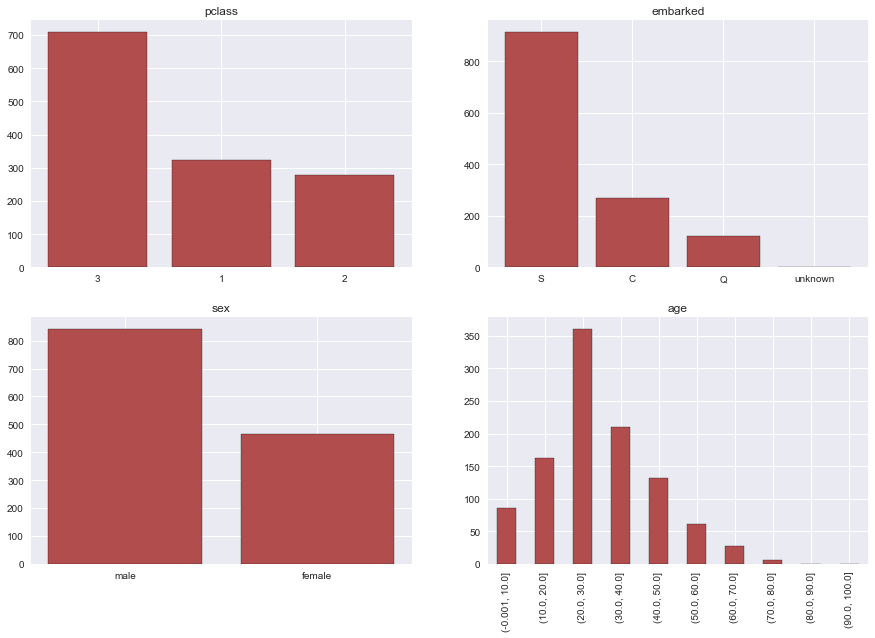

In [19]:
def bar_plot(df, category):
    counts = df[category].value_counts()
    plt.bar(range(len(counts)), counts.values, align='center', edgecolor="k")
    plt.xticks(range(len(counts)), counts.index.values, size='small')
    plt.title(category)
    
plt.figure(figsize = (15,10))
plt.subplot(221)
bar_plot(categ_titanic, 'pclass')
plt.subplot(222)
bar_plot(categ_titanic, 'embarked')
plt.subplot(223)
bar_plot(categ_titanic, 'sex')
plt.subplot(224)
bins= [i*10 for i in range(11)]
out = pd.cut(categ_titanic['age'], bins=bins, include_lowest=True)
out.value_counts(sort=False).plot.bar(edgecolor = 'k')
plt.title('age')
plt.show()  

### 3.3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

u    0.775401
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
Name: cabin, dtype: float64


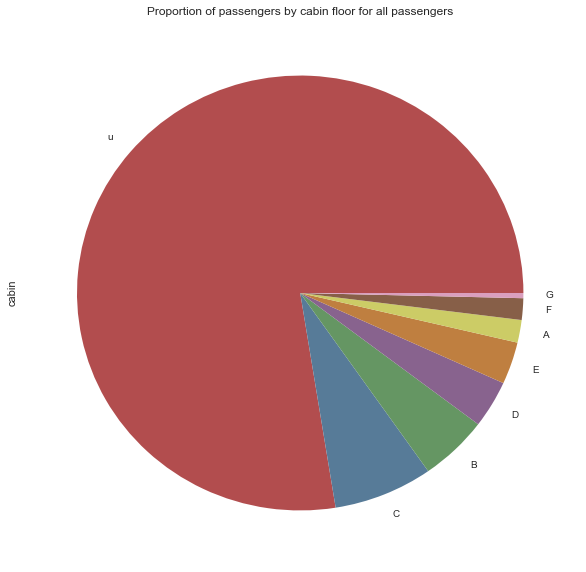

In [20]:
# Extract the cabin floors from the first letter of the cabins
cabin_floors = categ_titanic.cabin.str[0]

# Compute the total number of passengers
num_passengers = len(cabin_floors.tolist())
# Get the number of passengers per floor and compute the proportions
cabin_floors_proportions = cabin_floors.value_counts()/num_passengers
print(cabin_floors_proportions)

plt.figure(figsize = (10,10))
cabin_floors_proportions.plot.pie()
plt.title('Proportion of passengers by cabin floor for all passengers')

C    0.319728
B    0.221088
D    0.156463
E    0.139456
A    0.074830
F    0.071429
G    0.017007
Name: cabin, dtype: float64


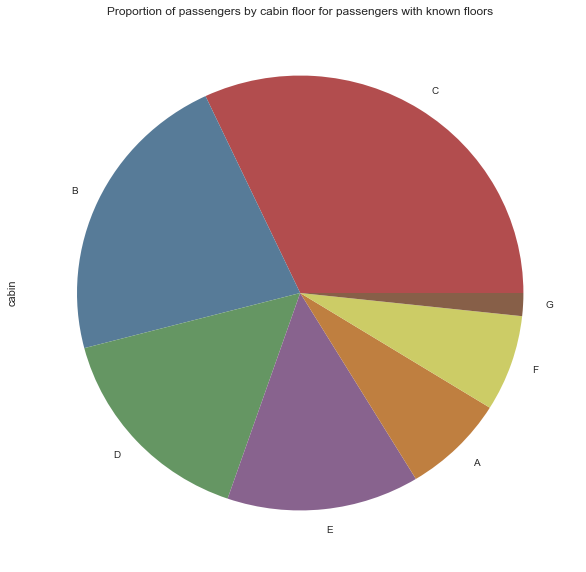

In [21]:
# Extract the cabin floors from the first letter of the cabins
cabin_floors = categ_titanic.cabin.str[0]
cabin_floors = cabin_floors[cabin_floors.str.contains("u|T") == False]

# Compute the total number of passengers
num_passengers = len(cabin_floors.tolist())
# Get the number of passengers per floor and compute the proportions
cabin_floors_proportions = cabin_floors.value_counts()/num_passengers
print(cabin_floors_proportions)

plt.figure(figsize = (10,10))
cabin_floors_proportions.plot.pie()
plt.title('Proportion of passengers by cabin floor for passengers with known floors')

### 3.4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

TODO : Pie chart?? based on the percentages or on the total number? Proportion = survived in class 1 / all passengers or all in class 1

In [22]:
def compute_survival_proportions(df, by_category):
    # Groupe the passengers by travel class
    travel_classes = df.groupby(by_category)
    # Get the average of passengers that survived for each class
    survival_per_class = travel_classes[['survived']].mean()
    survival_per_class['died'] = 1-survival_per_class
    print(survival_per_class)
    return survival_per_class

        survived      died
pclass                    
1       0.619195  0.380805
2       0.429603  0.570397
3       0.255289  0.744711


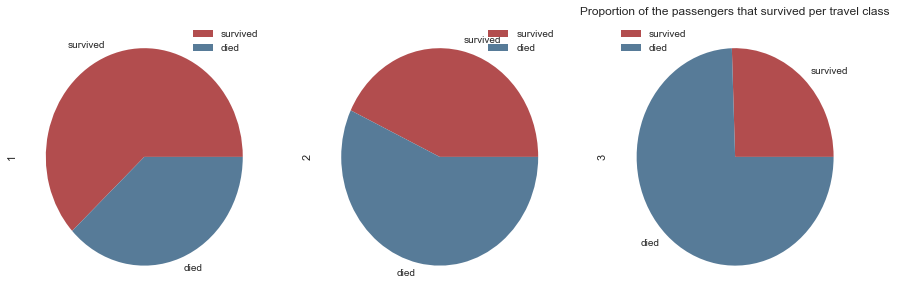

In [23]:
survival_class = compute_survival_proportions(categ_titanic, ['pclass'])
suvival_class_transpose = survival_class.transpose()

suvival_class_transpose.plot.pie(subplots = True, figsize = (15,5))
plt.title('Proportion of the passengers that survived per travel class')

### 3.5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

               survived      died
pclass sex                       
1      female  0.965278  0.034722
       male    0.340782  0.659218
2      female  0.886792  0.113208
       male    0.146199  0.853801
3      female  0.490741  0.509259
       male    0.152130  0.847870


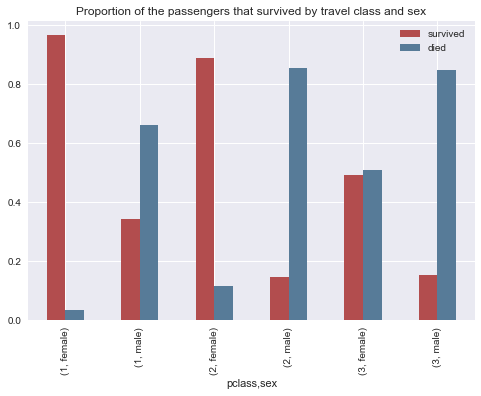

In [24]:
survival_class_sex = compute_survival_proportions(categ_titanic, ['pclass', 'sex'])
plt.figure(figsize = (10,10))
survival_class_sex.plot.bar()
plt.title('Proportion of the passengers that survived by travel class and sex')

### 3.6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [25]:
# Compute the median
median_age = categ_titanic['age'].median(skipna = True)
print("Number of passengers with the median age :",(categ_titanic['age'] == median_age).sum()) 

('Number of passengers with the median age :', 32)


There are too many people with the median age. It is not possible to cut based on the median and obtain equal sized categories. 

In [26]:
# Sort by age
age_sorted = categ_titanic.sort_values(['age'])
# Keep rows where age is not nan
age_sorted = age_sorted[np.isfinite(age_sorted['age'])]
# Get the number of passengers for which the age is given
num_passengers = len(age_sorted['age'].tolist())
# Break up the dataframe into two equal proportions by age category : young and old
age_sorted.loc[:(num_passengers//2),'age_categ']= 'young'
age_sorted.loc[(num_passengers//2):,'age_categ']= 'old'
#----------------------------------------------------------------------------------------------------

# Plot the survival proportions
survival_age_class_sex = compute_survival_proportions(age_sorted, ['age_categ','pclass', 'sex'])
print("Index is unique: ",survival_age_class_sex.index.is_unique)

                         survived      died
age_categ pclass sex                       
old       1      female  0.963964  0.036036
                 male    0.333333  0.666667
          2      female  0.871429  0.128571
                 male    0.080645  0.919355
          3      female  0.467532  0.532468
                 male    0.157407  0.842593
young     1      female  0.954545  0.045455
                 male    0.538462  0.461538
          2      female  0.939394  0.060606
                 male    0.382353  0.617647
          3      female  0.480000  0.520000
                 male    0.187970  0.812030
('Index is unique: ', True)
